<h1>Lab One: Understanding Table Data</h1>
<b>By Michael Watts, Maya Muralidhar, Nora Potenti, and Adam Ashcraft </b>

<h2>Part 1: Business Understanding </h2>

This is a data set of payment information provided by New York companies in the public sector. According to the Kaggle page, these companies are legally required to provide this data in accordance with Section 2800 of Public Authorities Law. It includes various types of payment such as salary, overtime, performance, extra forms of compensation, etc. The payment information is divided between five industrial categories: operational, administrative and clerical, technical and engineering, professional, managerial, and executive. It also has more defining items for the individual employees such as if they are full or part time, or paid by the state government for their work, not a company.

The goal of our data analytics is to determine how much and in what ways an employee should be compensated based on his or her category and full time status in the public sector of New York. This information would be helpful for both companies and employees in the public and private sector. For companies in the public sector, this data would inform them what they have to pay various working categories to stay competitive, that is offer comparable pay to the rest of that industry. Likewise, for employees, this data would inform them based on their group and full time status if they are being paid at competitive level at their current job. This is especially helpful because discussing salary among or between employees is considered taboo in the workforce.

To measure the success of our algorithm, we would need further data. According to Retensa, a company focused on improving the retention rates at companies, 64% of public sector industry leaders across the country have issues with retention. Assuming this as the average, companies in New York could adjust their pay according to our analysis. After this we could survey companies and see if the amount of companies fearing employee turnover is less than the average provided by Retensa. If it is, we could assume our payment rates are competitive enough to encourage the majority of employees to stay.

The outcomes of regression on this dataset would not be used as a mandate, but rather to eliminate outliers and provide suggestions as to a reasonable level of compensation.  On a training set, we would want results within a few standard deviations of the actual total compensation.
<hr>
Kaggle Dataset Link: https://www.kaggle.com/new-york-state/nys-salary-information-for-the-public-sector

Retensa Employment Link: https://retensa.com/clients/clients-by-industry/retain-government-employees/

<h1>Part 2: Data Understanding </h1>

In [230]:
# load the employee dataset
import pandas as pd
import numpy as np
import warnings

#read in and describe the data set
dataFrame = pd.read_csv('salary-information-for-industrial-development-agencies.csv') 
dataFrame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 20 columns):
Authority Name                       2156 non-null object
Fiscal Year End Date                 2156 non-null object
Has Employees                        110 non-null object
Last Name                            2046 non-null object
Middle Initial                       803 non-null object
First Name                           2046 non-null object
Title                                2046 non-null object
Group                                2046 non-null object
Department                           342 non-null object
Pay Type                             2046 non-null object
Exempt Indicator                     2046 non-null object
Base Annualized Salary               2046 non-null float64
Actual Salary Paid                   2046 non-null float64
Overtime Paid                        2046 non-null float64
Performance Bonus                    2046 non-null float64
Extra Pay             

So we can see, most data is shoved into a simple non null object and there appears to be a large amount of missing data, sometimes as many as 2046 entries missing. Let’s see if we cannot make this data a little cleaner and more usable. First, we can remove any row that has a “Y” value for “Paid by Another Entity” or “Paid by State or Local Government.” This data is valid and important, but since we are concerned with how public sector businesses compensate their employees, we do not care about employees that are not compensated by their business. We can also remove any row of data that has a “N” in the “Has Employees” column. If there is no "N" we assume the data has been provided for that row. These business do not have to report their information to the state of New York and therefore have no data tied to them. The lack of any other data tied to company makes imputing unknown data difficult and likely ineffective due to the large amount of data needed to be imputed. They also according to the kaggle page, represent only 5% of the data of this set, and thus can be safely ignored.    


In [231]:
#give the data we are parsing out simplier names for the sake of removing 
dataFrame = dataFrame.rename(columns = {'Paid By Another Entity': 'paidByAnother', 'Paid by State or Local Government': 'paidByAnother2', 'Has Employees': 'hasValidData'})
dataFrame = dataFrame[dataFrame.paidByAnother != 'Y']
dataFrame = dataFrame[dataFrame.paidByAnother2 != 'Y']
dataFrame = dataFrame[dataFrame.hasValidData != 'N']
#now lets take a look at our data
dataFrame.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 25 to 2155
Data columns (total 20 columns):
Authority Name            1333 non-null object
Fiscal Year End Date      1333 non-null object
hasValidData              0 non-null object
Last Name                 1333 non-null object
Middle Initial            597 non-null object
First Name                1333 non-null object
Title                     1333 non-null object
Group                     1333 non-null object
Department                202 non-null object
Pay Type                  1333 non-null object
Exempt Indicator          1333 non-null object
Base Annualized Salary    1333 non-null float64
Actual Salary Paid        1333 non-null float64
Overtime Paid             1333 non-null float64
Performance Bonus         1333 non-null float64
Extra Pay                 1333 non-null float64
Other Compensation        1333 non-null float64
Total Compensation        1333 non-null float64
paidByAnother             1333 non-null obje

Next we will remove some data columns, which while important to the survey as a whole, are not important for our purposes of accurately estimating employee group compensation values. “hasValidData”, “paidByAnother”, and “paidByAnother2” have all already served their purpose of removing invalid data and can be removed. We can also remove any data involving names such as “Last Name”, “Middle Initial”, “First Name”, "Title", and “Authority Name”. Since we are not focusing on specific people or companies but rather groups, this information is unnecessary. We can also remove “Department.” While this value would be helpful in grouping employees by career, we already have the much better column “Group” for that. Group is better because it is standardized for the data set, not just a string value assigned by the employer. “Group” is also far more present, having no missing entries, relative to the “Department” column’s 1131 missing entries. The "Exempt Indicator" can also be removed. This column has to do with labor laws and is not relevant to our question.


In [232]:
#rename columns to make them easier to work with
dataFrame = dataFrame.rename(columns = {'Authority Name': 'aName', 'Last Name': 'lName', 
                                        'Middle Initial': 'mi', 
                                        'First Name':'fName', 'Exempt Indicator': 'ei'})
#delete columns as prior stated
dataFrame.drop(columns=['hasValidData', 'paidByAnother', 'paidByAnother2', 'aName', 'lName', 'mi', 
                        'fName', 'Title', 'ei', 'Department'], inplace=True)
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 25 to 2155
Data columns (total 10 columns):
Fiscal Year End Date      1333 non-null object
Group                     1333 non-null object
Pay Type                  1333 non-null object
Base Annualized Salary    1333 non-null float64
Actual Salary Paid        1333 non-null float64
Overtime Paid             1333 non-null float64
Performance Bonus         1333 non-null float64
Extra Pay                 1333 non-null float64
Other Compensation        1333 non-null float64
Total Compensation        1333 non-null float64
dtypes: float64(7), object(3)
memory usage: 114.6+ KB


Now that we have stripped away excess data, let’s encode the data we have into something more useful than just objects and floats. First, we can convert the date. The year range for this survey according to kaggle is 2011 to 2016. So we can encode the years starting with 2011 = 0, 2012 = 1, …, 2016 = 5. 


In [233]:
#rename column to make easier to work with
dataFrame = dataFrame.rename(columns = {'Fiscal Year End Date':'Year'})
#convert datatype from strings to date objects
dataFrame['Year'] = dataFrame['Year'].astype(np.datetime64)
# grabs the year from the date object and sets it to our scale
def setYearData(x):
    
    x = x.year
    if (x == 2011):
        return 0
    if (x == 2012):
        return 1
    if (x == 2013):
        return 2
    if (x == 2014):
        return 3
    if (x == 2015):
        return 4
    if (x == 2016):
        return 5
#sets the date to be simply the year
dataFrame['Year'] = dataFrame['Year'].apply(setYearData)
cluster_df = dataFrame.copy()
#now lets look at our data set
dataFrame.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 25 to 2155
Data columns (total 10 columns):
Year                      1333 non-null int64
Group                     1333 non-null object
Pay Type                  1333 non-null object
Base Annualized Salary    1333 non-null float64
Actual Salary Paid        1333 non-null float64
Overtime Paid             1333 non-null float64
Performance Bonus         1333 non-null float64
Extra Pay                 1333 non-null float64
Other Compensation        1333 non-null float64
Total Compensation        1333 non-null float64
dtypes: float64(7), int64(1), object(2)
memory usage: 114.6+ KB


Now our dates are divided on year scale! Next, let's encode our groups.

In [234]:
#create encoding
tempPDF = pd.get_dummies(dataFrame['Group'],prefix='Group')
#show encoding
tempPDF.head()

,Group_Administrative/Clerical,Group_Executive,Group_Managerial,Group_Operational,Group_Professional,Group_Technical/Engineering
25,0,0,1,0,0,0
26,0,0,1,0,0,0
27,0,0,0,0,1,0
28,0,0,1,0,0,0
29,0,0,1,0,0,0


In [235]:
#now add the encoded category into the dataframe and drop the old group
dataFrameGroups = dataFrame.copy()
dataFrame = pd.concat([dataFrame,pd.get_dummies(dataFrame['Group'], prefix='Group')],axis=1)
dataFrame.drop(columns = ['Group'], inplace = True)
dataFrame.info()       
                  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 25 to 2155
Data columns (total 15 columns):
Year                             1333 non-null int64
Pay Type                         1333 non-null object
Base Annualized Salary           1333 non-null float64
Actual Salary Paid               1333 non-null float64
Overtime Paid                    1333 non-null float64
Performance Bonus                1333 non-null float64
Extra Pay                        1333 non-null float64
Other Compensation               1333 non-null float64
Total Compensation               1333 non-null float64
Group_Administrative/Clerical    1333 non-null uint8
Group_Executive                  1333 non-null uint8
Group_Managerial                 1333 non-null uint8
Group_Operational                1333 non-null uint8
Group_Professional               1333 non-null uint8
Group_Technical/Engineering      1333 non-null uint8
dtypes: float64(7), int64(1), object(1), uint8(6)
memory usage: 112.0+ KB


Next we change the "Pay Type" column from an object to an encoded binary. Since employees can only be either Full Time (represented as "FT" in the data) or Part Time (represented as "PT" in the data), we can encode FT to be 0 and PT to be 1.
<table>
    Pay Type Encoding:
    <tbody>
        <tr><td>Full Time:</td> <td>0</td><tr>
        <tr><td>Part Time:</td> <td>1</td><tr>
    </tbody>
</table>

In [236]:
#rename column to make easier to work with
dataFrame = dataFrame.rename(columns = {'Pay Type':'payType'})
#define a function to convert the values 
def convertPayType(x):
    
    if x == 'FT':
        return 0
    if x == 'PT':
        return 1

#convert the pay types to our binary
dataFrame['payType'] = dataFrame['payType'].apply(convertPayType)
#now lets look at our data set
dataFrame.info()    


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 25 to 2155
Data columns (total 15 columns):
Year                             1333 non-null int64
payType                          1333 non-null int64
Base Annualized Salary           1333 non-null float64
Actual Salary Paid               1333 non-null float64
Overtime Paid                    1333 non-null float64
Performance Bonus                1333 non-null float64
Extra Pay                        1333 non-null float64
Other Compensation               1333 non-null float64
Total Compensation               1333 non-null float64
Group_Administrative/Clerical    1333 non-null uint8
Group_Executive                  1333 non-null uint8
Group_Managerial                 1333 non-null uint8
Group_Operational                1333 non-null uint8
Group_Professional               1333 non-null uint8
Group_Technical/Engineering      1333 non-null uint8
dtypes: float64(7), int64(2), uint8(6)
memory usage: 112.0 KB


All of the remaining data is salary information, which can for our purposes be left as a floating point number. This will enable us to use it to find averages and deviations across groups, years, etc.

We are not missing any data. However, if we were, we could impute it. For example, if we were missing “Actual Salary Paid” for a row, we could group the data by the “Group” data we have encoded and “Year” data, and estimate the salary using either the median or average per group per year. 


<h1>Part 3: Data Visualization </h1>

<h2>3.1 Distributions</h2>

Part Time                False  True 
Group                                
Administrative/Clerical    282    182
Executive                  310    137
Managerial                  90     41
Operational                 40     37
Professional               146     37
Technical/Engineering       22      9


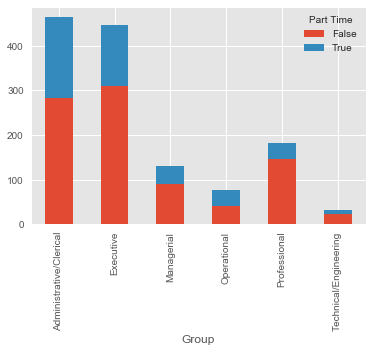

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt
dataFrameGroups = dataFrameGroups.rename(columns = {'Pay Type':'Part Time'})
dataFrameGroups['Part Time'] = dataFrameGroups['Part Time'].apply(convertPayType)
dataFrameGrouped = dataFrameGroups.groupby(by = ['Group'])
plt.style.use('ggplot')
employeeType = pd.crosstab([dataFrameGroups['Group']],
                       dataFrameGroups['Part Time'].astype(bool))
print(employeeType)

employeeType.plot(kind='bar', stacked=True)
plt.show()

In the above bar chart, the red portion of each bar represents the percentage of full time employees and the blue portion represents the percentage of part time employees. As we can see, every department employees more full time than part time employees. For some departments the gap between percentages is vast, such as Administrative/Clerical which employs approximately 55% more full time employees than part time. In other departments the gap is much smaller, like Operational, that only employees approximately 9% more full time employees than part time employees.  

C:\Users\Nora\Anaconda3.6\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


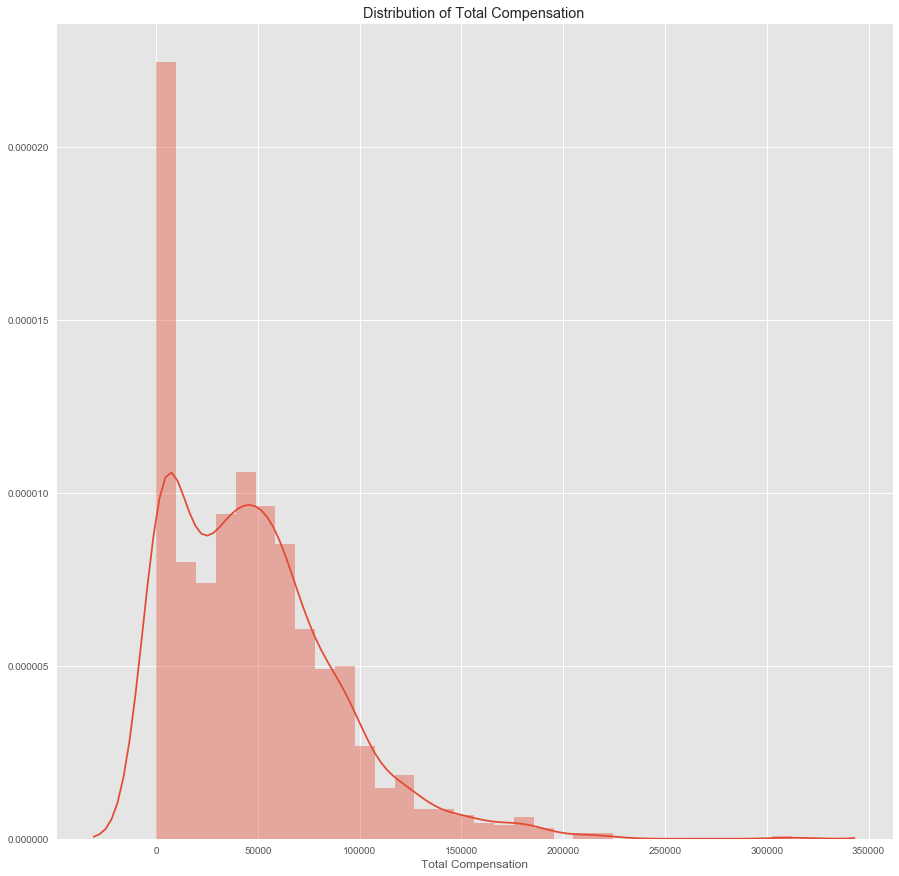

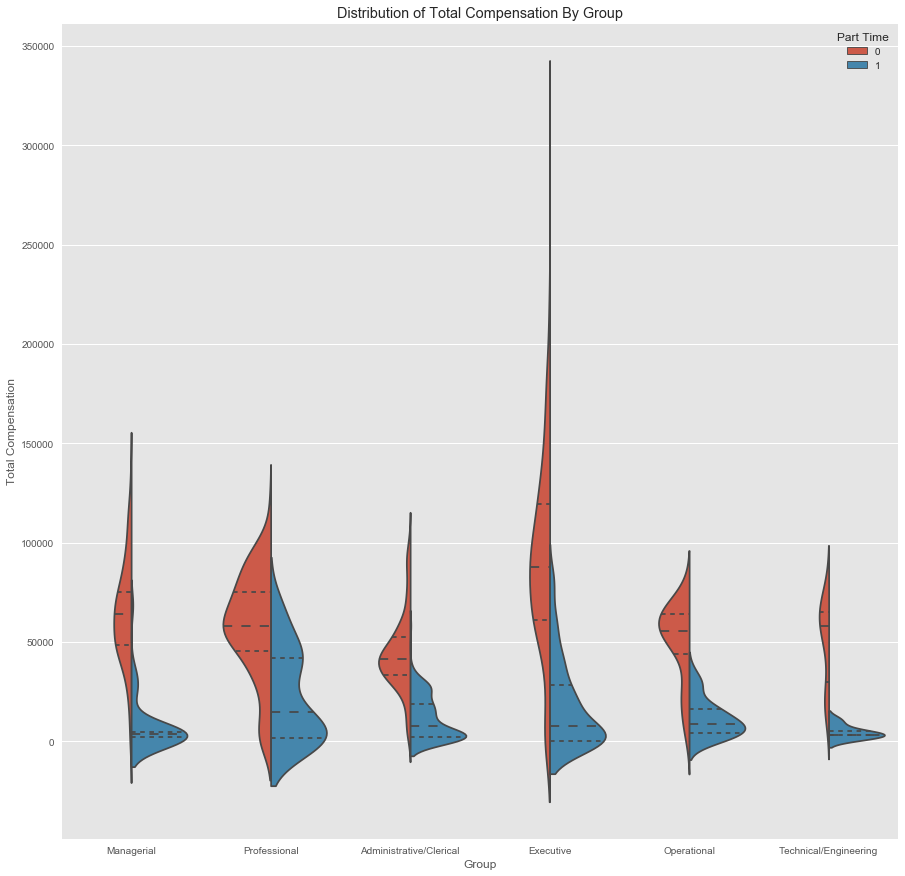

In [238]:

plt.style.use('ggplot')


fig = plt.figure(figsize=(15,15))

plt.title('Distribution of Total Compensation')
sns.distplot(dataFrameGroups['Total Compensation'])


fig = plt.figure(figsize=(15,15))
plt.title('Distribution of Total Compensation By Group')
sns.violinplot(x="Group", y="Total Compensation", hue="Part Time", data=dataFrameGroups, 
               split=True, inner="quart")


Above is a histogram of the total compensation for all groups in the data set. It follows a bimodal distribution. Below it is a breakdown of the total compensation by both group, and employee status as either full time (red) or part time (blue). Professional, Operational, and Technical/Engineering tended to be bimodal for full time employment. All other groups for full time employment where normally distributed. On the inverse side, for part time, only executive tended to be normally disturbed. All other groups were multimodal.   

C:\Users\Nora\Anaconda3.6\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


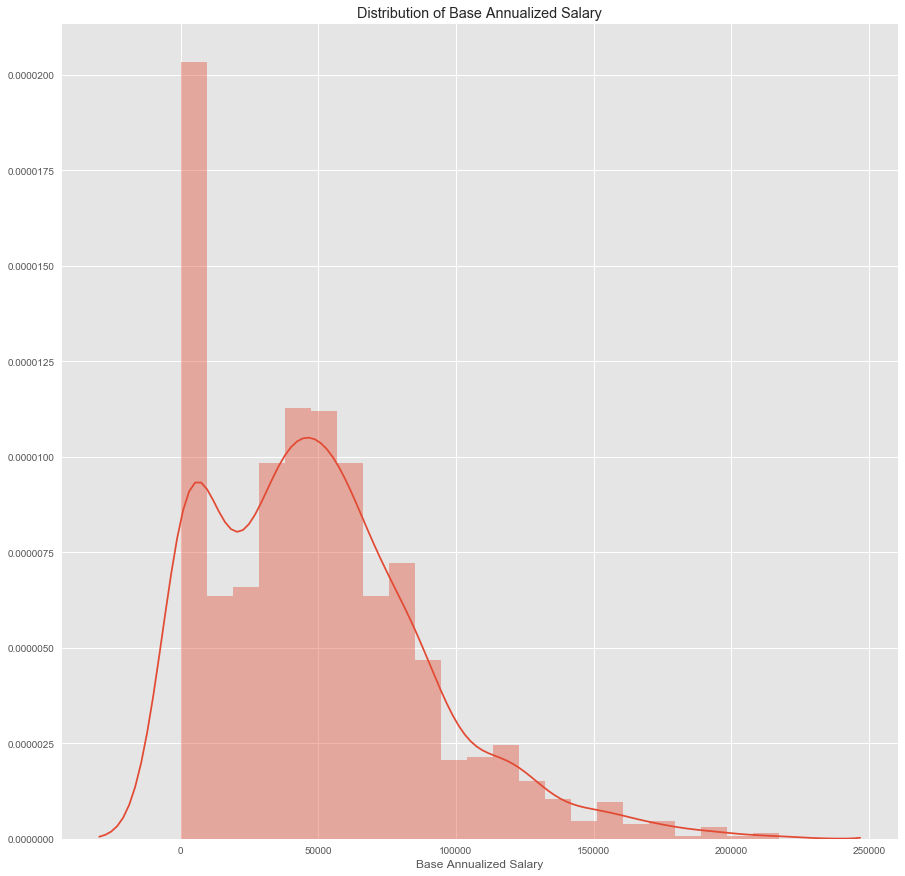

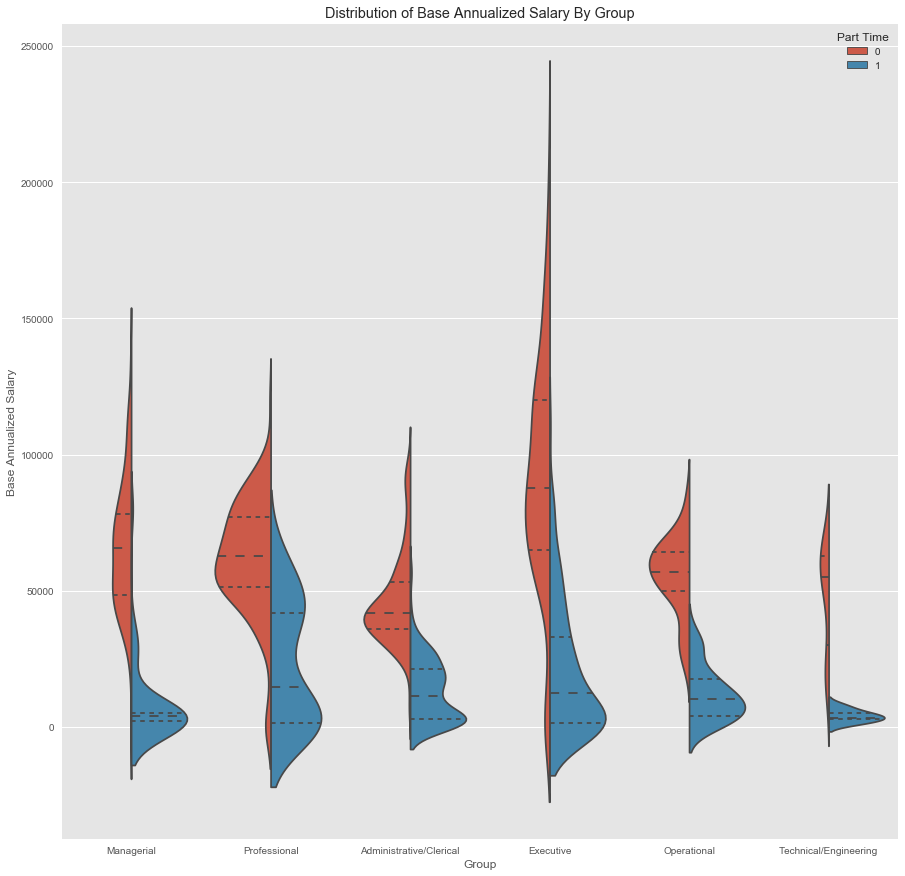

In [239]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(15,15))

plt.title('Distribution of Base Annualized Salary')
sns.distplot(dataFrameGroups['Base Annualized Salary'])


fig = plt.figure(figsize=(15,15))
plt.title('Distribution of Base Annualized Salary By Group')
sns.violinplot(x="Group", y="Base Annualized Salary", hue="Part Time", data=dataFrameGroups, 
               split=True, inner="quart")



Above is a histogram of the Base Annualized Salary for all groups in the data set. It follows a bimodal distribution. Below it is a breakdown of the total compensation by both group, and employee status as either full time (red) or part time (blue). Professional, Executive, Operational, and Technical/Engineering tended to be bimodal for full time employment. All other groups for full time employment where normally distributed. On the inverse side, for part time, only Executive and Technical/Engineering tended to be normally disturbed. All other groups were bimodal.        


C:\Users\Nora\Anaconda3.6\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


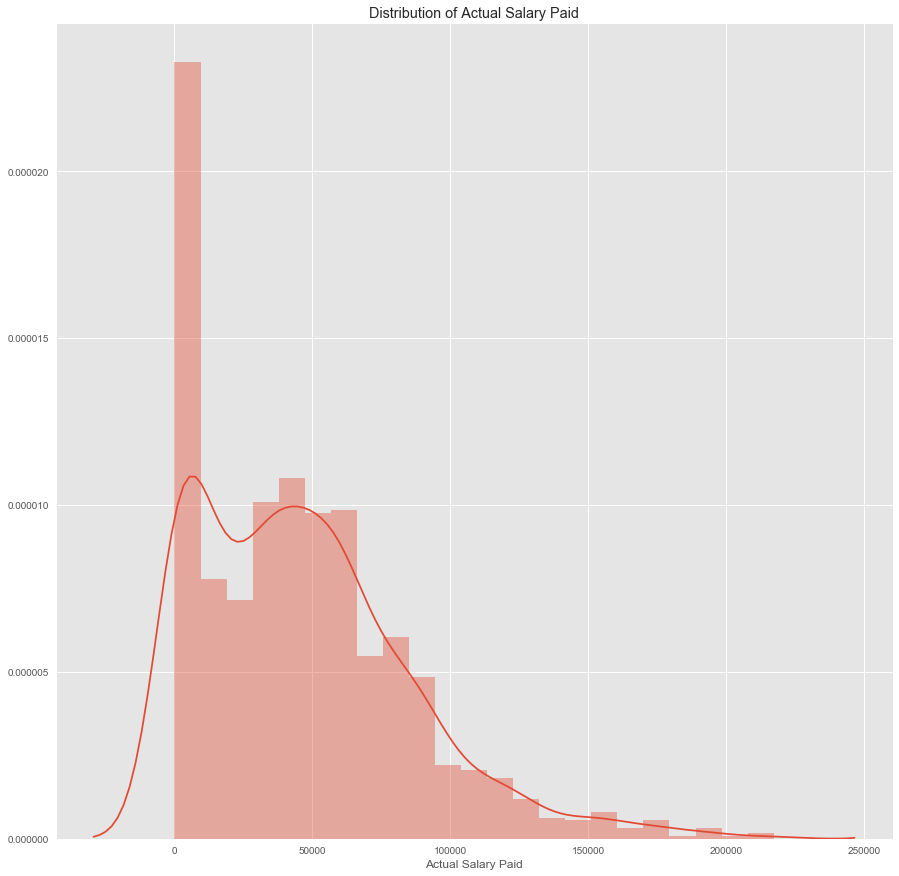

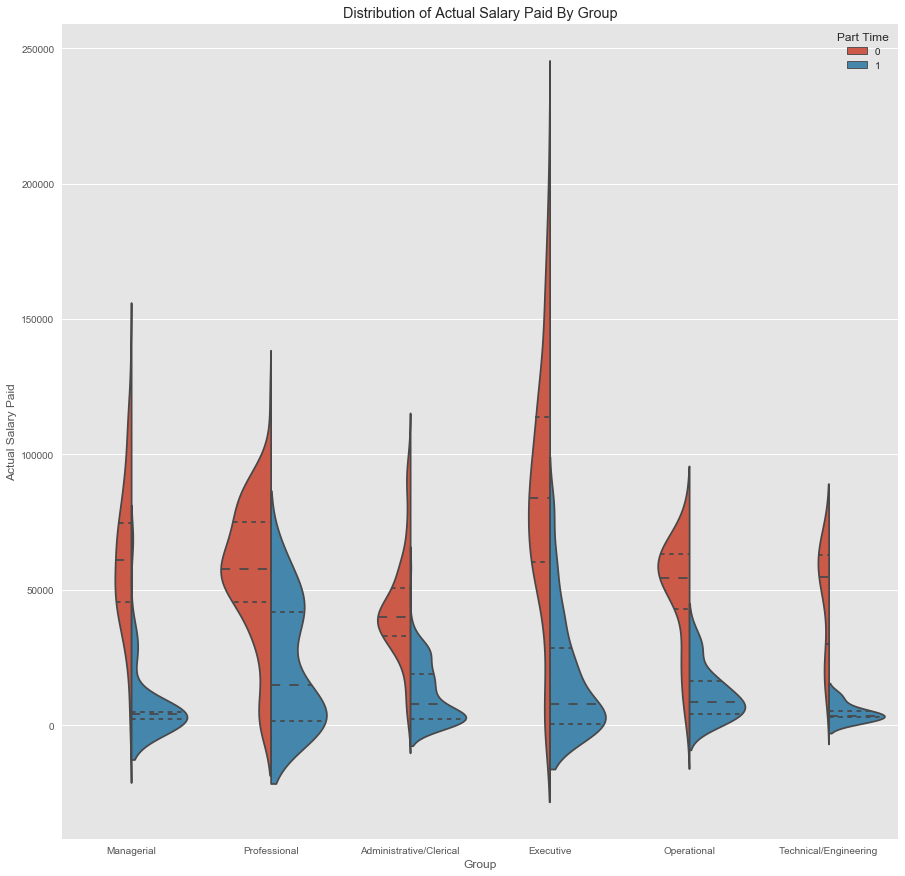

In [240]:
plt.style.use('ggplot')


fig = plt.figure(figsize=(15,15))

plt.title('Distribution of Actual Salary Paid')
sns.distplot(dataFrameGroups['Actual Salary Paid'])

fig = plt.figure(figsize=(15,15))
plt.title('Distribution of Actual Salary Paid By Group')
sns.violinplot(x="Group", y="Actual Salary Paid", hue="Part Time", data=dataFrameGroups, 
               split=True, inner="quart")



Above is a histogram of the Actual Salary Paid for all groups in the data set. It follows a bimodal distribution. Below it is a breakdown of the total compensation by both group, and employee status as either full time (red) or part time (blue). Professional, Executive and Technical/Engineering tended to be bimodal for full time employment. All other groups for full time employment where normally distributed. On the inverse side, for part time, only Executive and Technical/Engineering tended to be normally disturbed. All other groups were multimodal.        


C:\Users\Nora\Anaconda3.6\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


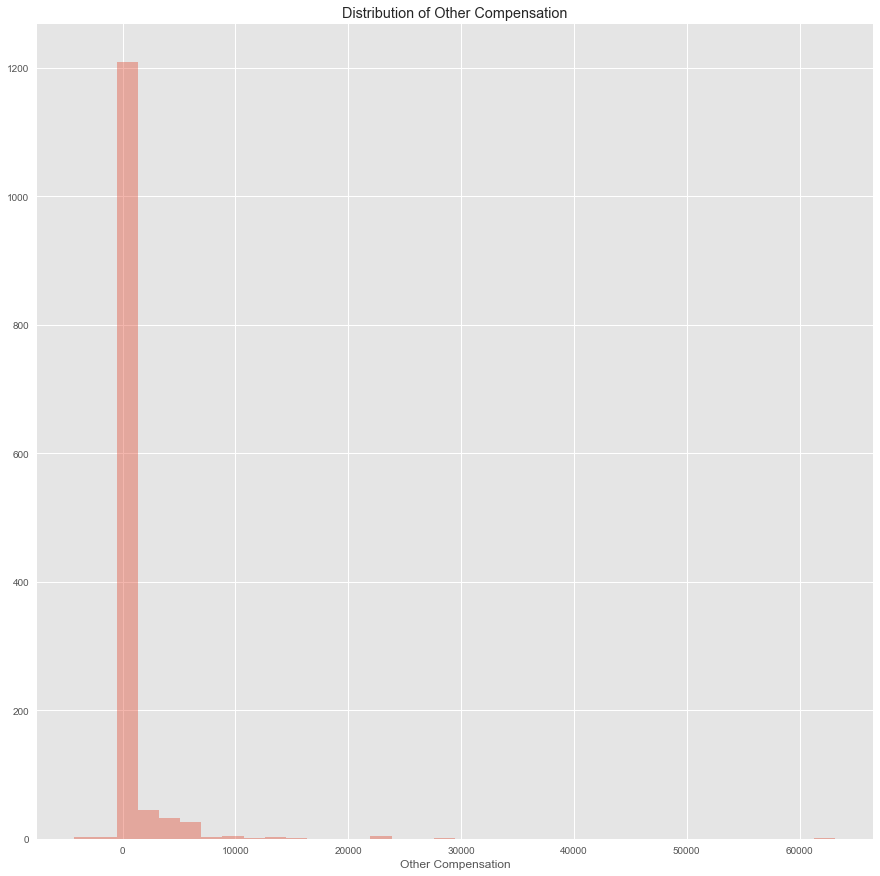

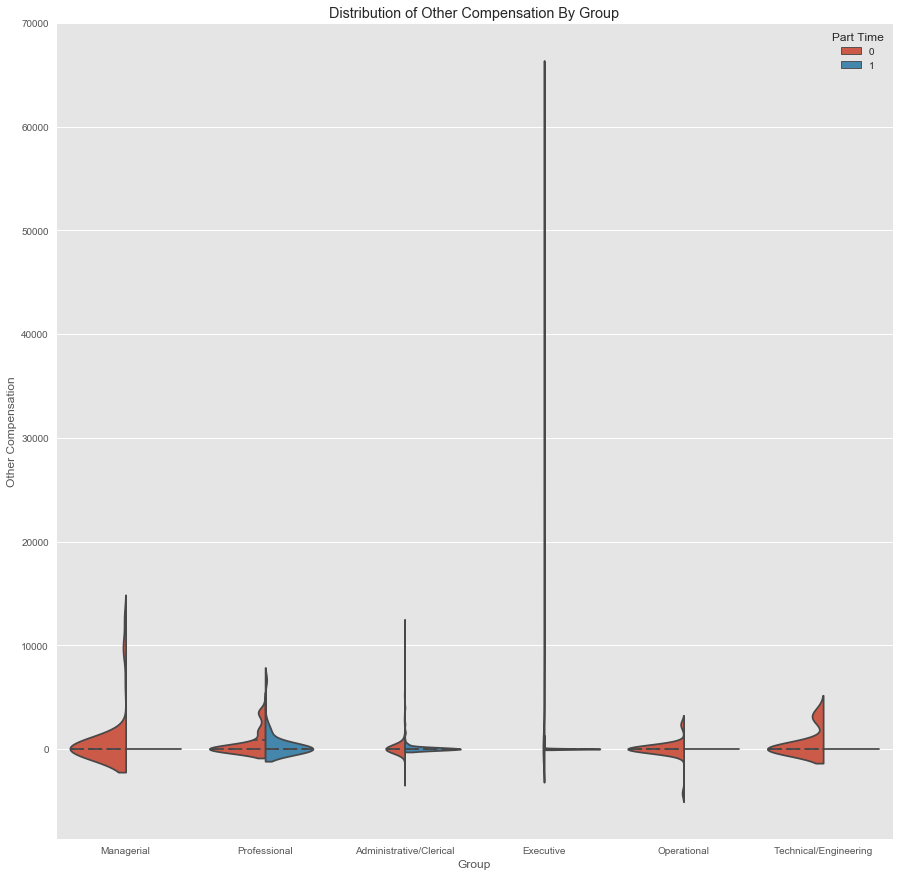

In [241]:
plt.style.use('ggplot')


a = 'Other Compensation';

fig = plt.figure(figsize=(15,15))

plt.title('Distribution of Other Compensation')
sns.distplot(dataFrameGroups[a], kde=False)

fig = plt.figure(figsize=(15,15))

plt.title('Distribution of Other Compensation By Group')
sns.violinplot(x="Group", y=a, hue="Part Time", data=dataFrameGroups, 
               split=True, inner="quart")


Above is a histogram of Other Compensation for all groups in the data set. It is centered around zero with outliers streching out to 60,000. Below it is a breakdown of the total compensation by both group, and employee status as either full time (red) or part time (blue). Managerial, Professional, Operational, and Technical/Engineering tended to be multimodal for full time employment. All other groups for full time employment where normally distributed. On the inverse side, all groups were normally distributed for part time.        

<h2>3.2 Data Relationships </h2>

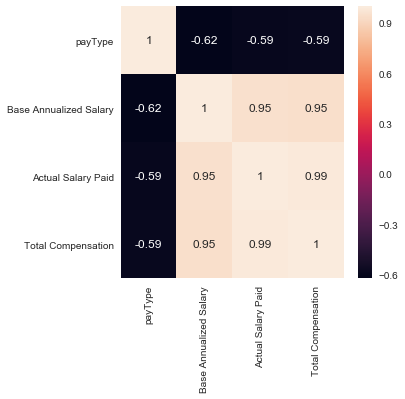

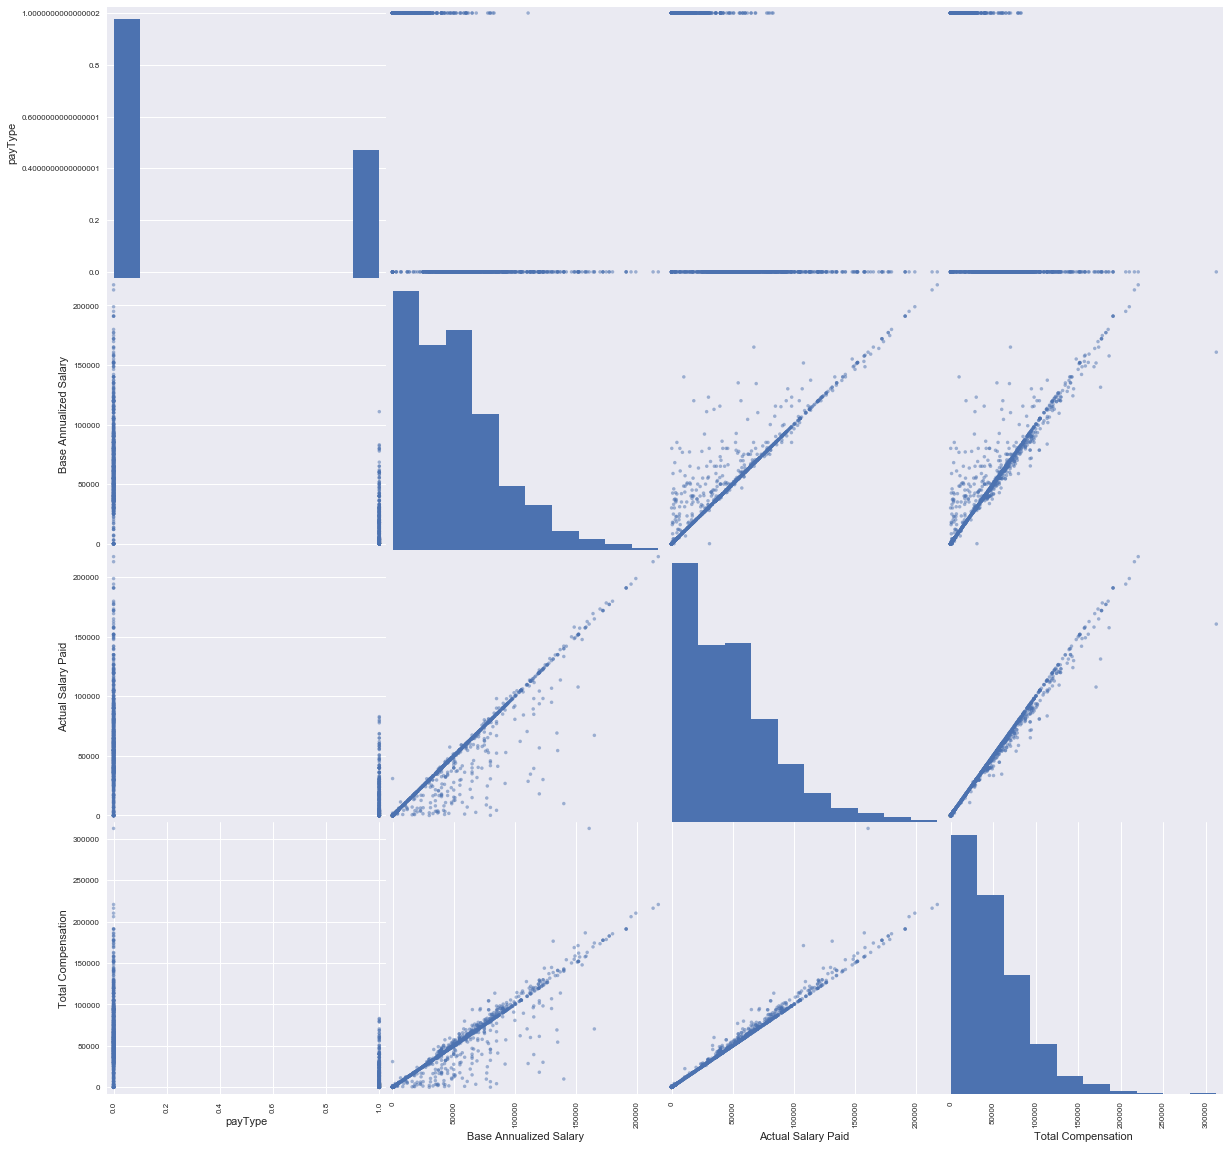

In [242]:

cmap = sns.set(style="darkgrid") # one of the many styles to plot using
heatmap_columns_1 = ['payType', 'Base Annualized Salary', 'Actual Salary Paid', 'Total Compensation']
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(dataFrame[heatmap_columns_1].corr(), cmap=cmap, annot=True)
# f.tight_layout()

from pandas.plotting import scatter_matrix

ax = scatter_matrix(dataFrame[heatmap_columns_1],figsize=(20, 20))


In this heat map, Base Annualized Salary, Actual Salary Paid, and Total Compensation are highly correlated.  Base Salary and Actual Salary should be correlated, as there would be a serious issue in pay if actual salary had nothing to do with base salary. In the corresponding scatterplot, we are able to visualize the numbers from the heatmap. We can see the high correlation between Actual Salary Paid, Total Compensation, and Base Annualized Salary. If we are using this data set to determine total compensation, we could eliminate either Base Salary or Actual Salary.  Pay Type has a very negative correlation with Base Salary, Actual Salary, and Total Compensation.

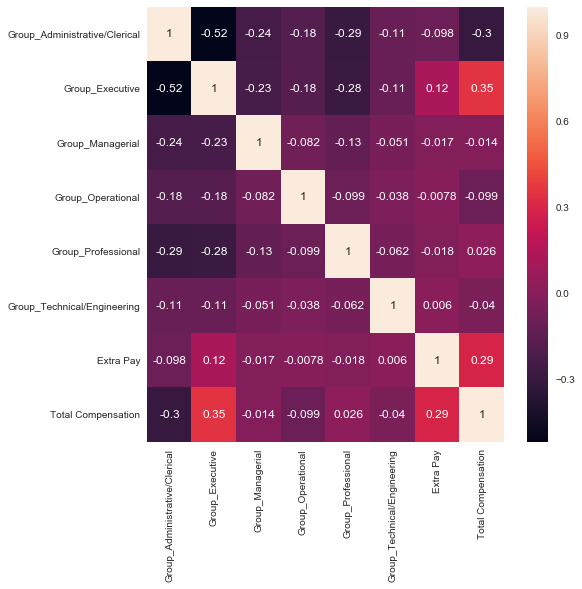

In [243]:
heatmap_columns_2 = ['Group_Administrative/Clerical', 'Group_Executive', 
                     'Group_Managerial', 'Group_Operational', 'Group_Professional', 
                     'Group_Technical/Engineering', 'Extra Pay', 'Total Compensation']
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(dataFrame[heatmap_columns_2].corr(), cmap=cmap, annot=True)

This heatmap looks at the correlation between the various employee groups, total compensation and extra pay.  For the most part, the groups don't correlate with total compensation or extra pay, but it seems the Executive group has some correlation with those fields. We can create a corresponding scatterplot matrix to see if that helps us visualize any correlation of these fields with the executive group. In the scatterplot matrix below, we can see that the Executive group has a larger range with a higher maximum total compensation than non-executive groups.

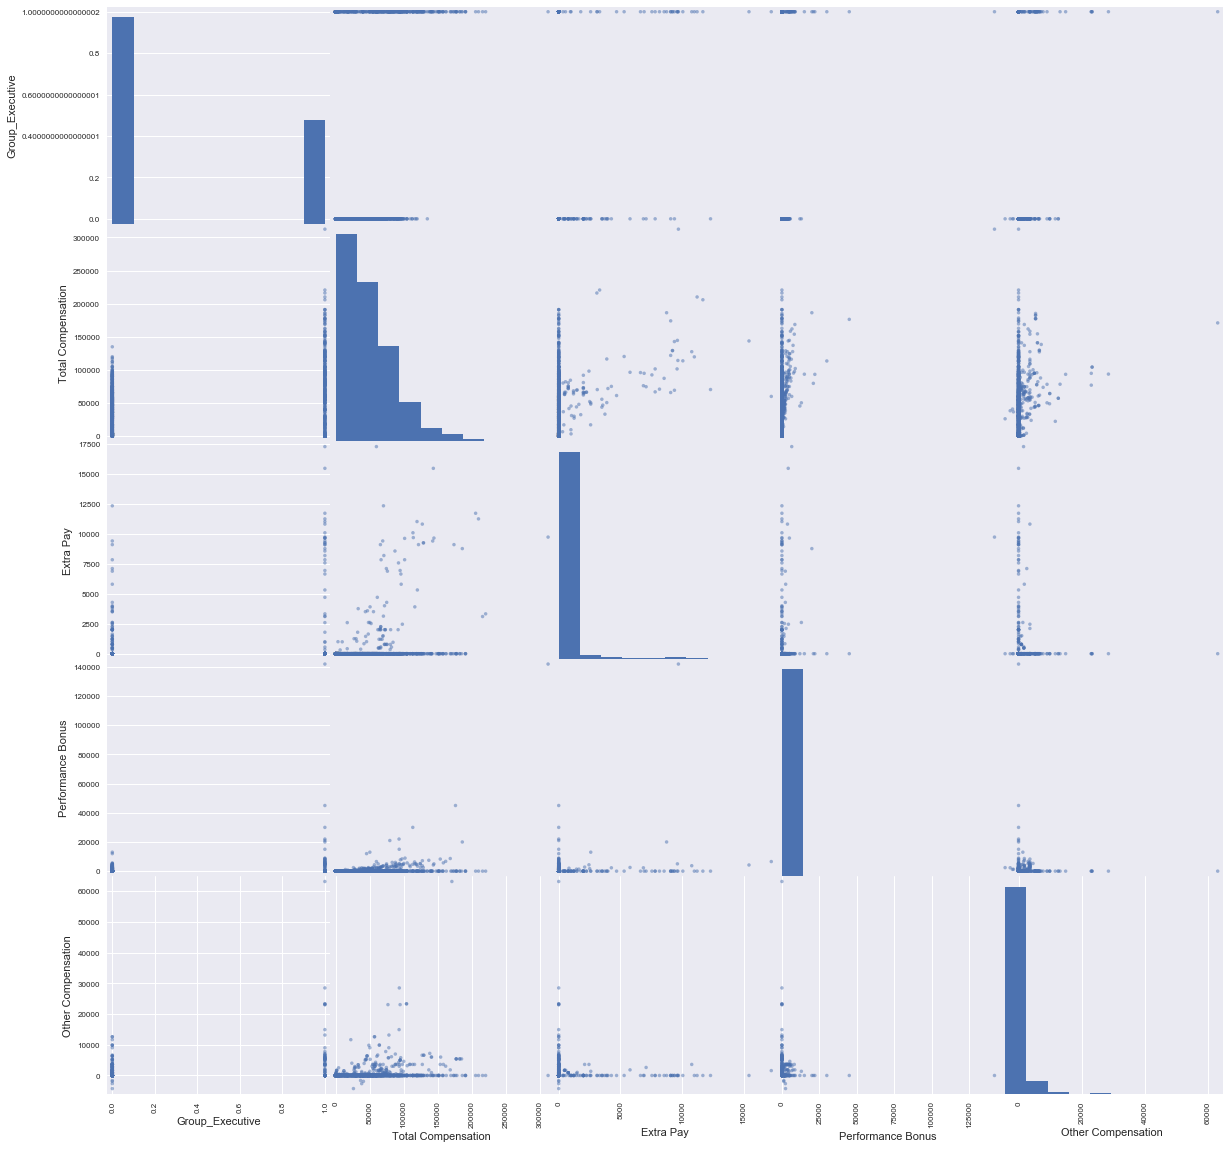

In [244]:
execColumns = ['Group_Executive', 'Total Compensation', 'Extra Pay', 'Performance Bonus', 'Other Compensation']

ax = scatter_matrix(dataFrame[execColumns],figsize=(20, 20))

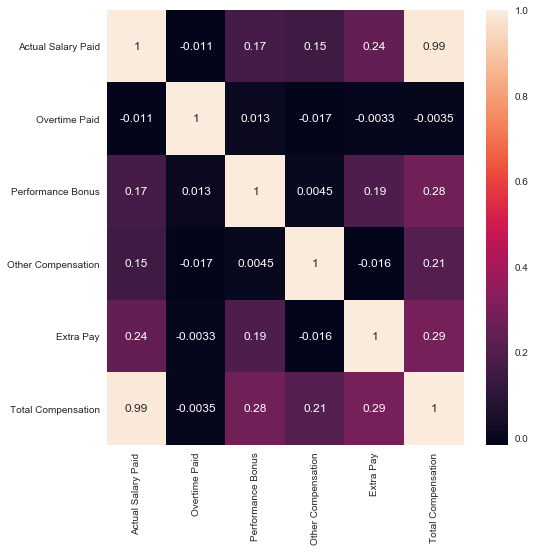

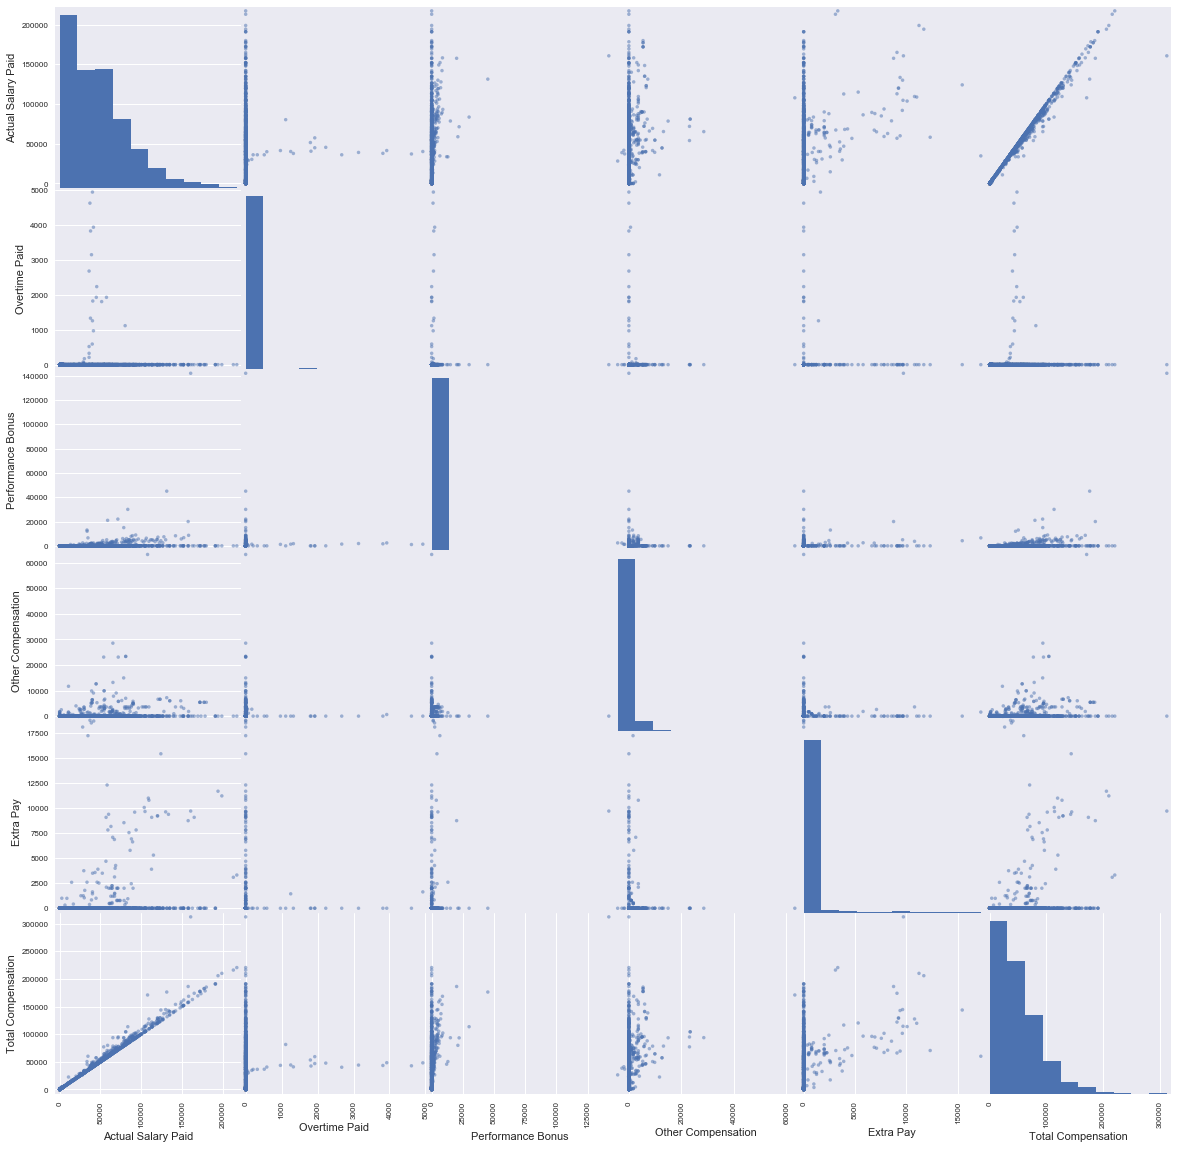

In [245]:
heatmap_columns_3 = ['Actual Salary Paid', 'Overtime Paid', 'Performance Bonus', 
                     'Other Compensation', 'Extra Pay', 'Total Compensation']
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(dataFrame[heatmap_columns_3].corr(), cmap=cmap, annot=True)

ax = scatter_matrix(dataFrame[heatmap_columns_3],figsize=(20, 20))

In the scatterplot matrix above, it appears that there may be some correlation between features when the features values do not equal zero. For example, it appears that there may be some correlation between Extra Pay and Actual Salary Paid when Extra Pay does not equal zero. It may be helpful for both companies and employees to know what kind of additional pay can be expected based on an employee's base salary, in the case there is any additional pay. To do this, we will remove data for which Extra Pay equals zero and plot it against Actual Salary Paid, and do the same for Overtime Paid, Performance Bonus, and Other Compensation as well.

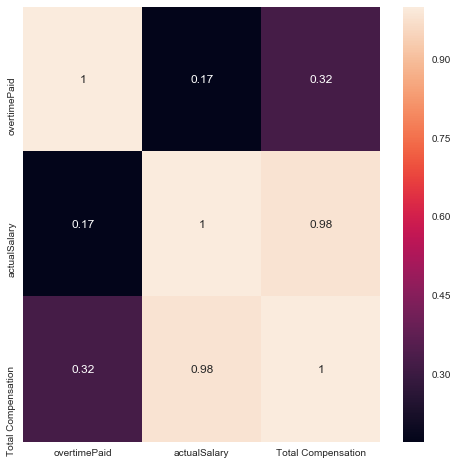

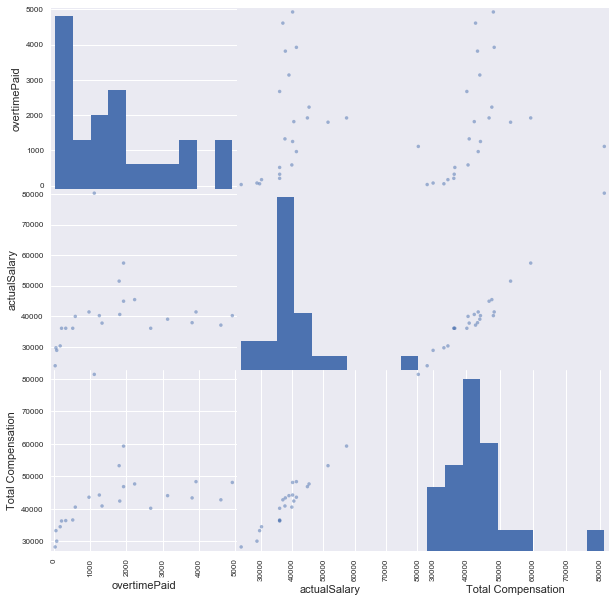

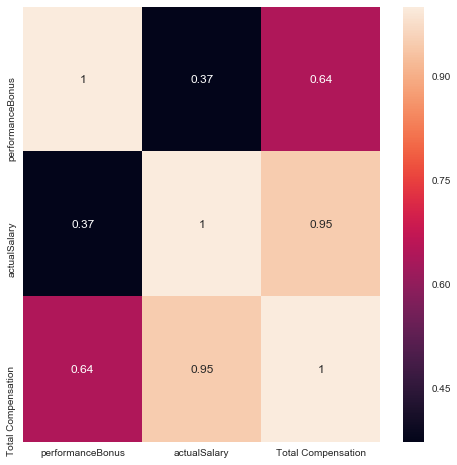

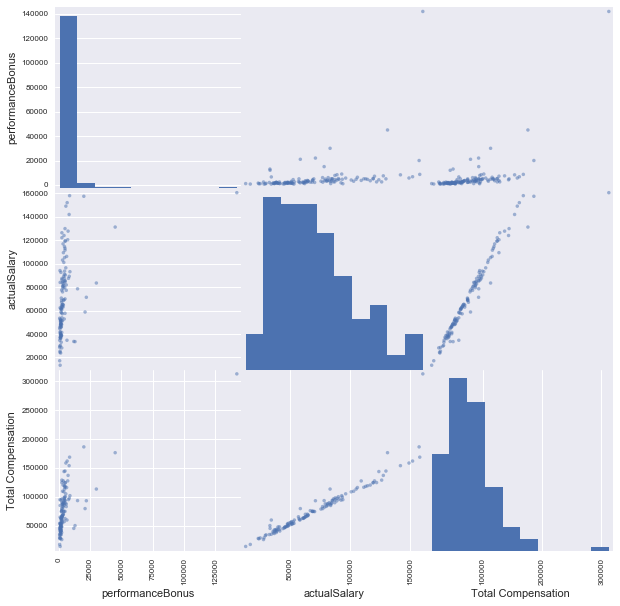

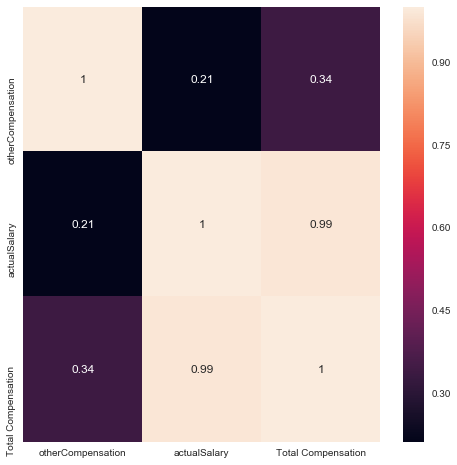

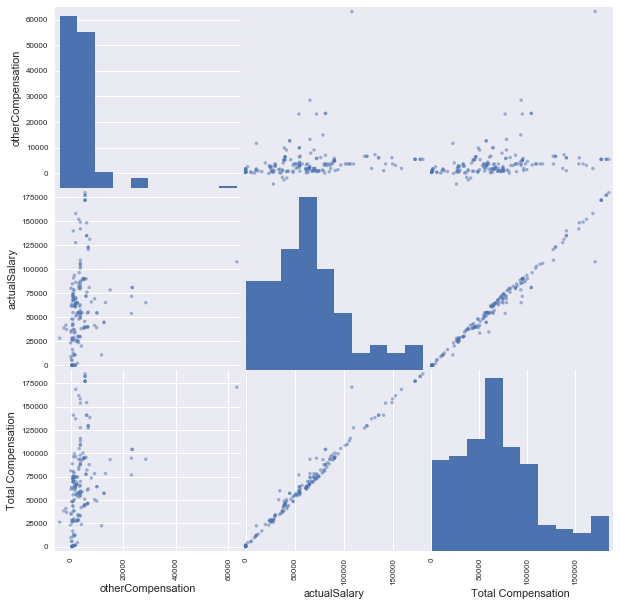

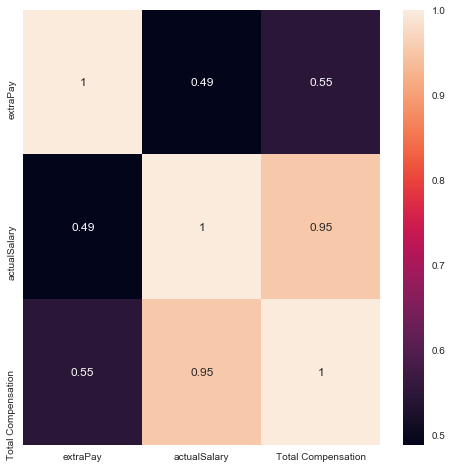

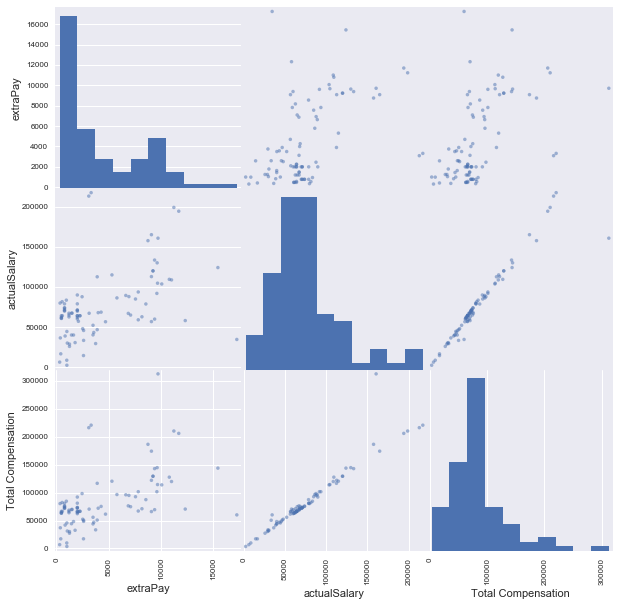

In [246]:
dataFrame = dataFrame.rename(columns = {'Actual Salary Paid': 'actualSalary', 'Overtime Paid': 'overtimePaid', 'Performance Bonus': 'performanceBonus',
                                        'Other Compensation': 'otherCompensation', 'Extra Pay': 'extraPay'})
extraPayData = dataFrame[dataFrame.extraPay != 0]
overtimeData = dataFrame[dataFrame.overtimePaid != 0]
performanceBonusData = dataFrame[dataFrame.performanceBonus != 0]
otherCompData = dataFrame[dataFrame.otherCompensation != 0]


# overtime pay
heatmap_columns_4 = ['overtimePaid','actualSalary','Total Compensation']
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(overtimeData[heatmap_columns_4].corr(), cmap=cmap, annot=True)

ax = scatter_matrix(overtimeData[heatmap_columns_4],figsize=(10, 10))

# performance bonus
heatmap_columns_5 = ['performanceBonus', 'actualSalary', 'Total Compensation']
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(performanceBonusData[heatmap_columns_5].corr(), cmap=cmap, annot=True)

ax = scatter_matrix(performanceBonusData[heatmap_columns_5],figsize=(10, 10))

# other compensation
heatmap_columns_6 = ['otherCompensation', 'actualSalary', 'Total Compensation']
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(otherCompData[heatmap_columns_6].corr(), cmap=cmap, annot=True)

ax = scatter_matrix(otherCompData[heatmap_columns_6],figsize=(10, 10))

# extra pay
heatmap_columns_7 = ['extraPay', 'actualSalary', 'Total Compensation']
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(extraPayData[heatmap_columns_7].corr(), cmap=cmap, annot=True)

ax = scatter_matrix(extraPayData[heatmap_columns_7],figsize=(10, 10))

From these heatmaps and scatterplot matrices, we can see that there does appear to be correlation between the different types of non-base-salary pay. With this information, we can see that if an employee is in fact receiving any additional compensation, we can use this correlation to predict the appropriate amount of compensation based on their base salary.

# Extra Analysis: Clustering Based on Numerical Features
There are 6 different kinds of employee groups this dataset covers.  It's possible that someone looking for employment in a different field than their own will have little knowledge of the offerings in other fields, and only know what they would like their pay to be, if they want to be paid overtime or receive a bonus, etc.  The goal here is to see if we can successfully cluster these groups based on the numerical features in the dataset.

In [247]:
from sklearn.cluster import KMeans
group_mapping = {'Administrative/Clerical': 0, 'Executive': 1, 'Managerial': 2, 'Operational': 3, 'Professional': 4, 'Technical/Engineering': 5}
cluster_df.replace({'Pay Type' : {'FT': 0, 'PT': 1}, 
                    'Group' : group_mapping}, inplace=True)
cluster_label = pd.DataFrame(cluster_df['Group'].values, columns=['Actual Label'])
cluster_df.drop(columns=['Group'], inplace=True)
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 25 to 2155
Data columns (total 9 columns):
Year                      1333 non-null int64
Pay Type                  1333 non-null int64
Base Annualized Salary    1333 non-null float64
Actual Salary Paid        1333 non-null float64
Overtime Paid             1333 non-null float64
Performance Bonus         1333 non-null float64
Extra Pay                 1333 non-null float64
Other Compensation        1333 non-null float64
Total Compensation        1333 non-null float64
dtypes: float64(7), int64(2)
memory usage: 104.1 KB


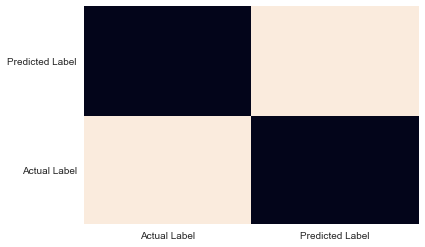

In [248]:
kmeans = KMeans(n_clusters=6).fit(cluster_df.values)
cluster_label['Predicted Label'] = kmeans.labels_
# plot the correlation matrix 
plt.pcolor(cluster_label[['Actual Label', 'Predicted Label']].corr()) # do the feature correlation plot

# fill in the indices
plt.yticks(np.arange(0.5, 2, 1), ['Actual Label', 'Predicted Label'])
plt.xticks(np.arange(0.5, 2, 1), ['Actual Label', 'Predicted Label'])
plt.show()

Based on this correlation matrix, it doesn't seem like k means did a particularly good job grouping the data points in a way that would reflect the group they're in.  If that were the case, there would be less variance in predicted labels within actual labels or a greater proportion of a predicted label in each group.  Let's look at how the groups look in terms of Base Annualized Salary and Year.

Text(0,0.5,'Total Compensation')

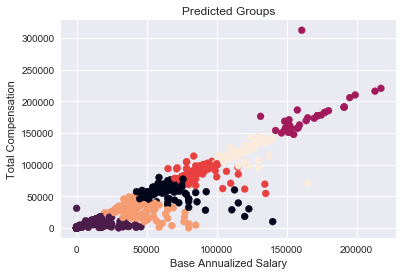

In [249]:
plt.title('Predicted Groups')
plt.scatter(cluster_df["Base Annualized Salary"].values, cluster_df["Total Compensation"].values, c=cluster_label['Predicted Label'].values)
plt.xlabel("Base Annualized Salary")
plt.ylabel("Total Compensation")

Text(0,0.5,'Total Compensation')

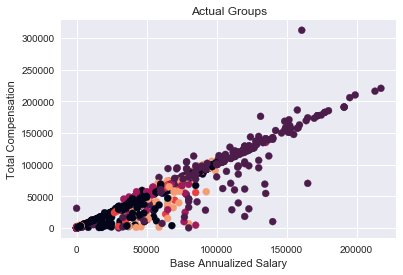

In [250]:
plt.title('Actual Groups')
plt.scatter(cluster_df["Base Annualized Salary"].values, cluster_df["Total Compensation"].values, c=cluster_label['Actual Label'].values)
plt.xlabel("Base Annualized Salary")
plt.ylabel("Total Compensation")

The clusters appear to correspond to intervals of the base salary.  Other features such as actual salary paid and total compensation correlate strongly as shown in the earlier heat map, so it makes sense that the algorithm would group the points in such a way.  In addition, other features such as Overtime Paid and Performance Bonus are only greater than 0 for a small percentage of the dataset.  In conclusion, information about pay alone is not enough to determine the employment group.